In [1]:
!pip install torchinfo

### Import Libraries

In [2]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import numpy as np
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
from tabulate import tabulate

In [3]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

### Configuration

In [5]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


### Seed Value

In [6]:
seed = 3
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Loading Dataset

In [11]:
data_dir = "/kaggle/input/cotton-dataset/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection/Original Dataset/Original Dataset"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, image_name))
        labels.append(class_name)

df = pd.DataFrame({"file_path": file_paths, "label": labels})
#df['label'] = df['label'].str.strip()
df = df.sample(frac=1).reset_index(drop=True)

In [12]:
label_map = {label: idx for idx, label in enumerate(sorted(df['label'].unique()))}
num_classes = len(label_map)

Class: Leaf Redding, Count: 578
Class: Curl Virus, Count: 431
Class: Herbicide Growth Damage, Count: 280
Class: Healthy Leaf, Count: 257
Class: Bacterial Blight, Count: 250
Class: Leaf Hopper Jassids, Count: 225
Class: Leaf Variegation, Count: 116


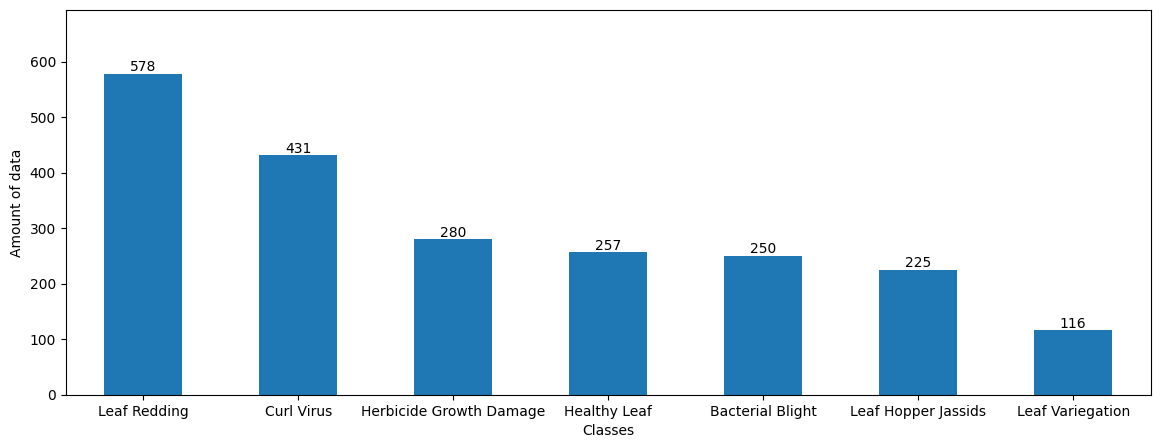

In [13]:
class_counts_train = df['label'].value_counts()

for class_name, count in class_counts_train.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(14, 5))
ax = class_counts_train.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
for i, count in enumerate(class_counts_train):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(class_counts_train) * 1.2)
plt.show()

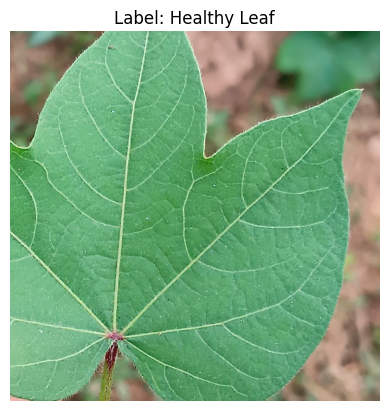

In [18]:
random_index = random.randint(1, len(df) - 1)
random_row = df.iloc[random_index]

file_path = random_row['file_path']
label = random_row['label']

image = Image.open(file_path)
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

### Train-Test-Validation Split (Ratio 70:15:15)

In [19]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30, 
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50, 
                                            stratify=temp_dataframe['label'], random_state=42)

In [20]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  1495
Validation Data:  321
Test Data:  321
-------------------------------------------
Total amounts of data in the dataset:  2137


In [21]:
class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_df['label'].value_counts()

train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Train Dataset
Class                      Count
-----------------------  -------
Leaf Redding                 404
Curl Virus                   302
Herbicide Growth Damage      196
Healthy Leaf                 180
Bacterial Blight             175
Leaf Hopper Jassids          157
Leaf Variegation              81

Validation Dataset
Class                      Count
-----------------------  -------
Leaf Redding                  87
Curl Virus                    65
Herbicide Growth Damage       42
Healthy Leaf                  38
Bacterial Blight              37
Leaf Hopper Jassids           34
Leaf Variegation              18

Test Dataset
Class                      Count
-----------------------  -------
Leaf Redding                  87
Curl Virus                    64
Herbicide Growth Damage       42
Healthy Leaf                  39
Bacterial Blight              38
Leaf Hopper Jassids           34
Leaf Variegation              17


### Device Variable

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Checkpoint

In [23]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

### Dataset Class, Dataloader and Transform

In [25]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.label_map = label_map

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [26]:
train_batch = 32
val_batch = 8

def data_transfrom():
    normalize = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor()])

    train_dataset = ImageDataset (
        train_dataframe,
        normalize,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_df,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=2)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=2)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=2)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

### Neural Network (ResNet)

In [28]:
num_classes = len(label_map)  
learning_rate = 0.001

model = models.resnet50(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(model.fc.in_features, num_classes) 
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
summary(model, input_size=(train_batch, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 7]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│ 

### Training

In [30]:
start_time = time.time()

def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, num_epochs=20, early_stop_patience=20, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print('Training Loss: {:.3f} Acc: {:.3f}'.format(epoch_train_loss, epoch_train_acc))

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print('Validation Loss: {:.3f} Acc: {:.3f}'.format(epoch_val_loss, epoch_val_acc))

        # Check for early stopping
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path_checkpoints}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
        else:
            num_epochs_loss_greater = 0

        if consecutive_no_improvement >= early_stop_patience or num_epochs_loss_greater >= early_stop_patience:
            print(f"Early stopping criteria met. No improvement in validation accuracy or validation loss for {early_stop_patience} consecutive epochs. Training stopped.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, save_path_checkpoints=save_path_checkpoints)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('/kaggle/working/training_data.xlsx', index=False)

Epoch 1/20: 100%|██████████| 47/47 [00:10<00:00,  4.36it/s, acc=0.827, loss=0.516]

Training Loss: 0.516 Acc: 0.827


Validation Loss: 0.715 Acc: 0.779
Best model saved at epoch 1 with validation accuracy: 0.779


Epoch 2/20: 100%|██████████| 47/47 [00:10<00:00,  4.36it/s, acc=0.852, loss=0.429]

Training Loss: 0.429 Acc: 0.852


Validation Loss: 0.716 Acc: 0.816
Best model saved at epoch 2 with validation accuracy: 0.816


Epoch 3/20: 100%|██████████| 47/47 [00:10<00:00,  4.40it/s, acc=0.856, loss=0.424]

Training Loss: 0.424 Acc: 0.856


Validation Loss: 0.671 Acc: 0.819
Best model saved at epoch 3 with validation accuracy: 0.819


Epoch 4/20: 100%|██████████| 47/47 [00:10<00:00,  4.33it/s, acc=0.899, loss=0.276]

Training Loss: 0.276 Acc: 0.899


Validation Loss: 0.587 Acc: 0.816


Epoch 5/20: 100%|██████████| 47/47 [00:10<00:00,  4.39it/s, acc=0.913, loss=0.274]

Training Loss: 0.274 Acc: 0.913


Validation Loss: 0.660 Acc: 0.801


Epoch 6/20: 100%|██████████| 47/47 [00:10<00:00,  4.40it/s, acc=0.924, loss=0.197]

Training Loss: 0.197 Acc: 0.924


Validation Loss: 0.726 Acc: 0.804


Epoch 7/20: 100%|██████████| 47/47 [00:10<00:00,  4.34it/s, acc=0.938, loss=0.198]

Training Loss: 0.198 Acc: 0.938


Validation Loss: 0.389 Acc: 0.894
Best model saved at epoch 7 with validation accuracy: 0.894


Epoch 8/20: 100%|██████████| 47/47 [00:10<00:00,  4.37it/s, acc=0.949, loss=0.149]

Training Loss: 0.149 Acc: 0.949


Validation Loss: 0.364 Acc: 0.866


Epoch 9/20: 100%|██████████| 47/47 [00:10<00:00,  4.39it/s, acc=0.955, loss=0.149]

Training Loss: 0.149 Acc: 0.955


Validation Loss: 0.404 Acc: 0.872


Epoch 10/20: 100%|██████████| 47/47 [00:10<00:00,  4.37it/s, acc=0.924, loss=0.236]

Training Loss: 0.236 Acc: 0.924


Validation Loss: 0.390 Acc: 0.872


Epoch 11/20: 100%|██████████| 47/47 [00:10<00:00,  4.37it/s, acc=0.933, loss=0.209]

Training Loss: 0.209 Acc: 0.933


Validation Loss: 0.418 Acc: 0.854


Epoch 12/20: 100%|██████████| 47/47 [00:10<00:00,  4.38it/s, acc=0.959, loss=0.155]

Training Loss: 0.155 Acc: 0.959


Validation Loss: 0.376 Acc: 0.888


Epoch 13/20: 100%|██████████| 47/47 [00:10<00:00,  4.40it/s, acc=0.971, loss=0.102] 

Training Loss: 0.102 Acc: 0.971


Validation Loss: 0.461 Acc: 0.863


Epoch 14/20: 100%|██████████| 47/47 [00:10<00:00,  4.38it/s, acc=0.975, loss=0.0809]

Training Loss: 0.081 Acc: 0.975


Validation Loss: 0.661 Acc: 0.804


Epoch 15/20: 100%|██████████| 47/47 [00:10<00:00,  4.38it/s, acc=0.971, loss=0.1]   

Training Loss: 0.100 Acc: 0.971


Validation Loss: 0.616 Acc: 0.785


Epoch 16/20: 100%|██████████| 47/47 [00:10<00:00,  4.41it/s, acc=0.966, loss=0.0936]

Training Loss: 0.094 Acc: 0.966


Validation Loss: 0.419 Acc: 0.863


Epoch 17/20: 100%|██████████| 47/47 [00:10<00:00,  4.38it/s, acc=0.961, loss=0.121] 

Training Loss: 0.121 Acc: 0.961


Validation Loss: 0.342 Acc: 0.897
Best model saved at epoch 17 with validation accuracy: 0.897


Epoch 18/20: 100%|██████████| 47/47 [00:10<00:00,  4.40it/s, acc=0.974, loss=0.0822]

Training Loss: 0.082 Acc: 0.974


Validation Loss: 0.855 Acc: 0.813


Epoch 19/20: 100%|██████████| 47/47 [00:10<00:00,  4.41it/s, acc=0.978, loss=0.0673]

Training Loss: 0.067 Acc: 0.978


Validation Loss: 0.493 Acc: 0.869


Epoch 20/20: 100%|██████████| 47/47 [00:10<00:00,  4.41it/s, acc=0.988, loss=0.0384]

Training Loss: 0.038 Acc: 0.988


Validation Loss: 0.258 Acc: 0.938
Best model saved at epoch 20 with validation accuracy: 0.938
Early stopping criteria met. No improvement in validation accuracy or validation loss for 20 consecutive epochs. Training stopped.
Training Time: 260.27 seconds ---> 4.34 minutes


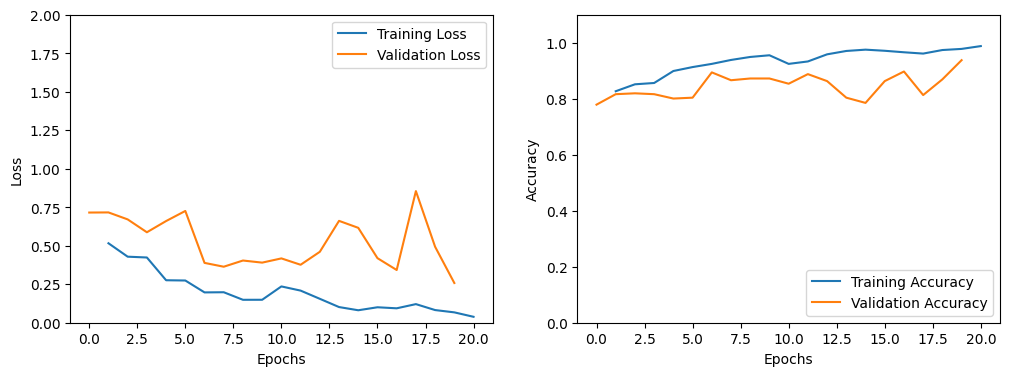

In [31]:
history = pd.read_excel('/kaggle/working/training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

### Evaluation

In [32]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy

In [33]:
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

Best model (from epoch 20) - Validation Loss: 0.258, Validation Accuracy: 0.938


In [34]:
start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.922
Test Time: 2.83 seconds ---> 0.05 minutes


In [36]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

class_names = [str(i) for i in range(num_classes)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, num_classes)
for i in range(num_classes):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.76      0.87        38
           1       0.97      0.97      0.97        64
           2       0.95      1.00      0.97        39
           3       1.00      0.98      0.99        42
           4       0.63      0.97      0.77        34
           5       0.97      0.87      0.92        87
           6       1.00      0.94      0.97        17

    accuracy                           0.92       321
   macro avg       0.93      0.93      0.92       321
weighted avg       0.94      0.92      0.93       321

Class 0 Accuracy: 0.763
Class 1 Accuracy: 0.969
Class 2 Accuracy: 1.000
Class 3 Accuracy: 0.976
Class 4 Accuracy: 0.971
Class 5 Accuracy: 0.874
Class 6 Accuracy: 0.941
